In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime
import json
from bs4 import BeautifulSoup
import requests
 
%matplotlib inline
grey = .6, .6, .6
 
# define a pair
fsym = "ETH"
tsym = "USD"
 
url = "https://www.cryptocompare.com/api/data/coinsnapshot/?fsym=" + \
       fsym + "&tsym=" + tsym
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
dic = json.loads(soup.prettify())
print(dic)

{'Response': 'Success', 'Message': 'This api will soon move to mi-api path.', 'Data': {'Algorithm': 'Ethash', 'ProofType': 'PoW', 'BlockNumber': 4928482, 'NetHashesPerSecond': 162610124494826.97, 'TotalCoinsMined': 97054572.40529999, 'BlockReward': 3.0, 'AggregatedData': {'TYPE': '5', 'MARKET': 'CCCAGG', 'FROMSYMBOL': 'ETH', 'TOSYMBOL': 'USD', 'FLAGS': '2', 'PRICE': '1008.51', 'LASTUPDATE': '1516269263', 'LASTVOLUME': '10', 'LASTVOLUMETO': '10037', 'LASTTRADEID': '171642028', 'VOLUMEDAY': '461391.28401132533', 'VOLUMEDAYTO': '467099841.9232843', 'VOLUME24HOUR': '2072516.6862620574', 'VOLUME24HOURTO': '1914419207.0743399', 'OPENDAY': '1024.9', 'HIGHDAY': '1068.83', 'LOWDAY': '949.56', 'OPEN24HOUR': '932.33', 'HIGH24HOUR': '1077.63', 'LOW24HOUR': '762.78', 'LASTMARKET': 'Bitfinex'}, 'Exchanges': [{'TYPE': '2', 'MARKET': 'BitBay', 'FROMSYMBOL': 'ETH', 'TOSYMBOL': 'USD', 'FLAGS': '2', 'PRICE': '1085', 'LASTUPDATE': '1516268669', 'LASTVOLUME': '6.40509214', 'LASTVOLUMETO': '6949.52497189999

In [2]:
market = []
d = dic['Data']['Exchanges']  # a list
for i in range(len(d)):
    market.append(d[i]['MARKET'])
    print(market[-1])

BitBay
Remitano
Bitstamp
LiveCoin
HitBTC
Quoine
Kraken
Tidex
Gatecoin
Cryptsy
WavesDEX
Yobit
CCEX
Exmo
BitTrex
BTCE
OKCoin
Coinroom
Coinbase
Cexio
Bitfinex
Lykke
Poloniex
Gemini


In [3]:
# Retrieve volume of ETH in each exchange
vol = []
d = dic['Data']['Exchanges']  # a list
for i in range(len(d)):
    vol.append([d[i]['MARKET'], round(float(d[i]['VOLUME24HOUR']),2)])
 
# sort a list of sublists according to 2nd item in a sublist
vol = sorted(vol, key=lambda x: -x[1])
 
# Cryptocurrency Markets according to Volume traded within last 24 hours
for e in vol:
    print("%10s%15.2f" % (e[0], e[1]))

  Coinbase      743356.23
  Bitfinex      625312.21
    Gemini      231123.07
  Bitstamp      188283.48
    Kraken      114778.18
  Poloniex       66195.88
   BitTrex       51689.84
    HitBTC       23005.44
     Cexio       20412.30
      Exmo        6580.19
    Quoine        1745.95
     Yobit         468.38
     Lykke         159.74
  LiveCoin         120.45
    BitBay          66.80
     Tidex          62.26
  Gatecoin          55.66
  Coinroom          13.33
  WavesDEX           2.33
  Remitano           0.00
   Cryptsy           0.00
      CCEX           0.00
      BTCE           0.00
    OKCoin           0.00


In [4]:
# Select Top 10 Cryptocurrency Markets
markets = [e[0] for e in vol][0:10]
print(markets)

['Coinbase', 'Bitfinex', 'Gemini', 'Bitstamp', 'Kraken', 'Poloniex', 'BitTrex', 'HitBTC', 'Cexio', 'Exmo']


In [5]:
def fetchCryptoOHLC_byExchange(fsym, tsym, exchange):
    """a function fetches a crypto OHLC price-series for fsym/tsym and stores
    it in a pandas DataFrame; uses specific Exchange as provided 
    src: https://www.cryptocompare.com/api/"""
 
    cols = ['date', 'timestamp', 'open', 'high', 'low', 'close']
    lst = ['time', 'open', 'high', 'low', 'close']
 
    timestamp_today = datetime.today().timestamp()
    curr_timestamp = timestamp_today
 
    for j in range(2):
        df = pd.DataFrame(columns=cols)
        url = "https://min-api.cryptocompare.com/data/histoday?fsym=" + fsym + \
              "&tsym=" + tsym + "&toTs=" + str(int(curr_timestamp)) + \
              "&limit=2000" + "&e=" + exchange
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        dic = json.loads(soup.prettify())
 
        for i in range(1, 2001):
            tmp = []
            for e in enumerate(lst):
                x = e[0]
                y = dic['Data'][i][e[1]]
                if(x == 0):
                    # timestamp-to-date
                    td = datetime.fromtimestamp(int(y)).strftime('%Y-%m-%d')
                    tmp.append(td)  #(str(timestamp2date(y)))
                tmp.append(y)
            if(np.sum(tmp[-4::]) > 0):
                df.loc[len(df)] = np.array(tmp)
        df.index = pd.to_datetime(df.date)
        df.drop('date', axis=1, inplace=True)
        curr_timestamp = int(df.iloc[0][0])
 
        if(j == 0):
            df0 = df.copy()
        else:
            data = pd.concat([df, df0], axis=0)
 
    return data.astype(np.float64)

In [6]:
# if a variable 'cp' exists, delete it
if ('cp' in globals()) or ('cp' in locals()): del cp
 
# download daily OHLC price-series for ETH/USD for a given 'market'
# extract close-price (cp)
 
print("%s/%s" % (fsym, tsym))
for market in markets:
    print("%12s... " % market, end="")
    df = fetchCryptoOHLC_byExchange(fsym, tsym, market)
    ts = df[(df.index > "2017-06-01") & (df.index <= "2017-11-05")]["close"]
    ts.name = market
    if ('cp' in globals()) or ('cp' in locals()):
        cp = pd.concat([cp, ts], axis=1, ignore_index=False)
    else:
        cp = pd.DataFrame(ts)
    print("downloaded")

ETH/USD
    Coinbase... downloaded
    Bitfinex... downloaded
      Gemini... downloaded
    Bitstamp... downloaded
      Kraken... downloaded
    Poloniex... downloaded
     BitTrex... downloaded
      HitBTC... downloaded
       Cexio... downloaded
        Exmo... downloaded


In [7]:
print(cp.head(10))
print(cp.tail(10))

            Coinbase  Bitfinex  Gemini  Bitstamp  Kraken  Poloniex  BitTrex  \
date                                                                          
2017-06-02    222.04    214.77  222.78       NaN  221.54    215.40   215.00   
2017-06-03    224.95    217.01  224.50       NaN  224.23    217.22   217.00   
2017-06-04    245.50    241.06  245.90       NaN  245.35    217.22   239.50   
2017-06-05    248.00    242.16  248.37       NaN  247.60    242.10   246.41   
2017-06-06    264.58    261.89  267.44       NaN  263.60    262.00   264.82   
2017-06-07    255.68    250.70  256.02       NaN  256.19    250.50   253.93   
2017-06-08    258.64    256.95  261.04       NaN  260.24    257.43   257.00   
2017-06-09    279.38    278.41  280.21       NaN  279.85    278.85   278.50   
2017-06-10    340.20    325.88  331.22       NaN  326.00    326.00   324.10   
2017-06-11    343.01    336.33  339.00       NaN  333.10    335.00   335.72   

            HitBTC   Cexio    Exmo  
date          

In [8]:
# To find average difference in daily closing price & supplement it with 1 std dev. 
dist = []
for i in range(cp.shape[1]):
    for j in range(i):
        if(i != j):
            x = np.array(cp.iloc[:,i], dtype=np.float32)
            y = np.array(cp.iloc[:,j], dtype=np.float32)
            diff = np.abs(x-y)
            avg = np.mean(diff)
            std = np.std(diff, ddof=1)
            dist.append([cp.columns[i], cp.columns[j], avg, std])
 
dist = sorted(dist, key=lambda x: -x[2])
print("%10s%10s%10s%10s\n" % ("Coin1", "Coin2", "Mean", "Std Dev"))
for e in dist:
    print("%10s%10s%10.5f%10.2f" % (e[0], e[1], e[2], e[3]))

     Coin1     Coin2      Mean   Std Dev

    Gemini  Bitfinex   2.15720      4.60
  Bitfinex  Coinbase   2.09936      2.81
    Gemini  Coinbase   1.24140      4.75
  Bitstamp  Coinbase       nan       nan
  Bitstamp  Bitfinex       nan       nan
  Bitstamp    Gemini       nan       nan
     Cexio    HitBTC   9.88586      8.28
     Cexio  Poloniex   9.68885      8.26
      Exmo     Cexio   9.57911      5.15
     Cexio   BitTrex   9.57860      8.27
     Cexio  Bitfinex   9.56675      7.96
     Cexio    Gemini   8.57643      8.20
     Cexio    Kraken   8.25853      6.54
     Cexio  Coinbase   7.84280      6.23
      Exmo   BitTrex   6.36484      5.35
      Exmo  Poloniex   6.22656      5.20
      Exmo    HitBTC   6.22166      5.00
      Exmo  Bitfinex   6.12471      5.01
      Exmo    Gemini   6.03809      6.21
      Exmo    Kraken   5.99089      4.36
      Exmo  Coinbase   5.74051      4.20
    HitBTC  Coinbase   2.78178      4.38
    HitBTC    Gemini   2.77681      5.61
    HitBTC    K

157 157


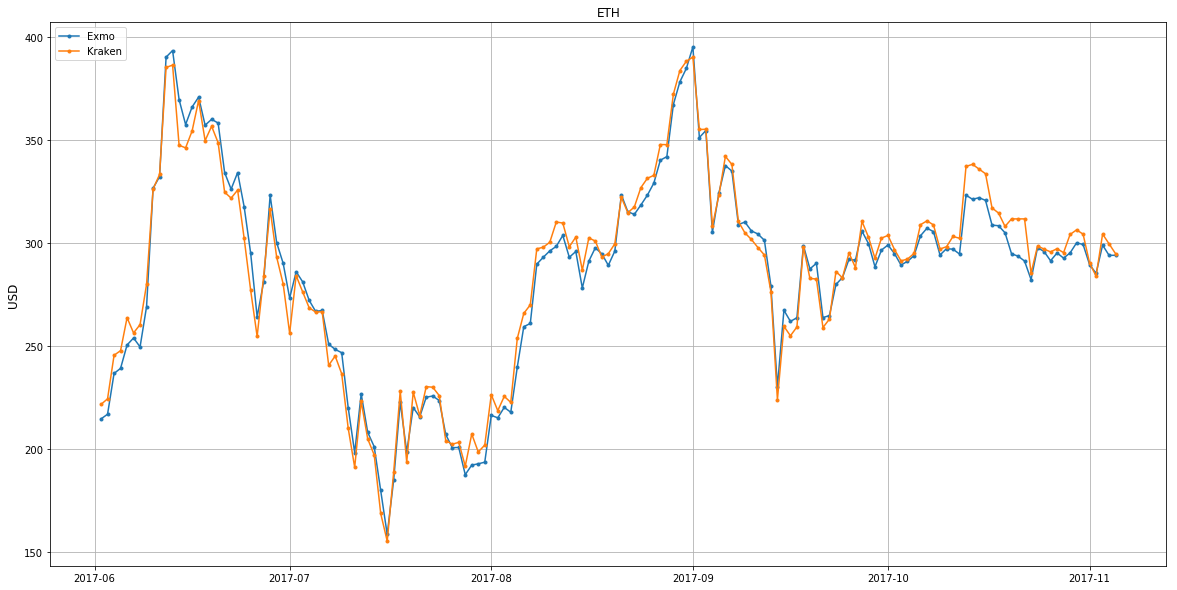

In [9]:
# Select two markets with the highest mean spread at the lowest standard deviation
# From results generated on 18 Jan 2018, I have selected Exmo & Kraken
market1 = "Exmo"
market2 = "Kraken"
 
df1 = fetchCryptoOHLC_byExchange(fsym, tsym, market1)
df2 = fetchCryptoOHLC_byExchange(fsym, tsym, market2)
 
# trim
df1 = df1[(df1.index > "2017-06-01") & (df1.index <= "2017-11-05")]
df2 = df2[(df2.index > "2017-06-01") & (df2.index <= "2017-11-05")]
 
# checkpoint
print(df1.close.shape[0], df2.close.shape[0])  # both sizes must be equal
 
# plotting
plt.figure(figsize=(20,10))
plt.plot(df1.close, '.-', label=market1)
plt.plot(df2.close, '.-', label=market2)
plt.legend(loc=2)
plt.title(fsym, fontsize=12)
plt.ylabel(tsym, fontsize=12)
plt.grid()

In [11]:
# Backtesting Stat Arb trading strategy for ETH/USD at Exmo and Kraken
#  cryptocurrency exchanges
 
# initial parameters
investment = 10000  # USD
account1, account2 = investment/2, investment/2  # USD
position = 0.5*(investment/2)  # USD
 
roi = []
ac1 = [account1]
ac2 = [account2]
money = []
pnl_exch1 = []
pnl_exch2 = []
trade_pnl = []
 
trade = False
n = df1.close.shape[0]  # number of data points
 
# running the backtest
for i in range(n):
    p1 = float(df1.close.iloc[i])
    p2 = float(df2.close.iloc[i])
    if(p1 > p2):
        asset1 = "SHORT"
        asset2 = "LONG"
        if(trade == False):
            open_p1 = p1  # open prices
            open_p2 = p2
            open_asset1 = asset1
            open_asset2 = asset2
            trade = True
            print("new traded opened")
            new_trade = False
        elif(asset1 == open_asset1):
            new_trade = False  # flag
        elif(asset1 == open_asset2):
            new_trade = True   # flag
 
    elif(p2 > p1):
        asset1 = "LONG"
        asset2 = "SHORT"
        if(trade == False):
            open_p1 = p1  # open prices
            open_p2 = p2
            open_asset1 = asset1
            open_asset2 = asset2
            trade = True
            print("new traded opened")
            new_trade = False
        elif(asset1 == open_asset1):
            new_trade = False  # flag
        elif(asset1 == open_asset2):
            new_trade = True   # flag
 
    if(i == 0):
        print(df1.close.iloc[i], df2.close.iloc[i], \
              asset1, asset2, trade, "----first trade info")
    else:
        if(new_trade):
 
            # close current position
            if(open_asset1 == "SHORT"):
                # PnL of both trades
                pnl_asset1 = open_p1/p1 - 1
                pnl_asset2 = p2/open_p2 -1
                pnl_exch1.append(pnl_asset1)
                pnl_exch2.append(pnl_asset2)
                print(open_p1, p1, open_p2, p2, open_asset1, \
                      open_asset2, pnl_asset1, pnl_asset2)
                # update both accounts
                account1 = account1 + position*pnl_asset1
                account2 = account2 + position*pnl_asset2
                print("accounts [USD] = ", account1, account2)
                if((account1 <=0) or (account2 <=0)):
                    print("--trading halted")
                    break
                # return on investment (ROI)
                total = account1 + account2
                roi.append(total/investment-1)
                ac1.append(account1)
                ac2.append(account2)
                money.append(total)
                print("ROI = ", roi[-1])
                print("trade closed\n")
                trade = False
 
                # open a new trade
                if(asset1 == "SHORT"):
                    open_p1 = p1
                    open_p2 = p2
                    open_asset1 = asset1
                    open_asset2 = asset2
                else:
                    open_p1 = p1
                    open_p2 = p2
                    open_asset1 = asset1
                    open_asset2 = asset2
                trade = True
                print("new trade opened", asset1, asset2, \
                      open_p1, open_p2)
 
            # close current position
            if(open_asset1 == "LONG"):
                # PnL of both trades
                pnl_asset1 = p1/open_p1 -1
                pnl_asset2 = open_p2/p2 - 1
                pnl_exch1.append(pnl_asset1)
                pnl_exch2.append(pnl_asset2)
                print(open_p1, p1, open_p2, p2, open_asset1, \
                      open_asset2, pnl_asset1, pnl_asset2)
                # update both accounts
                account1 = account1 + position*pnl_asset1
                account2 = account2 + position*pnl_asset2
                print("accounts [USD] = ", account1, account2)
                if((account1 <=0) or (account2 <=0)):
                    print("--trading halted")
                    break
                # return on investment (ROI)
                total = account1 + account2
                roi.append(total/investment-1)
                ac1.append(account1)
                ac2.append(account2)
                money.append(total)
                trade_pnl.append(pnl_asset1+pnl_asset2)
                print("ROI = ", roi[-1])
                print("trade closed\n")
                trade = False
 
                # open a new trade
                if(open_asset1 == "SHORT"):
                    open_p1 = p1
                    open_p2 = p2
                    open_asset1 = asset1
                    open_asset2 = asset2
                else:
                    open_p1 = p1
                    open_p2 = p2
                    open_asset1 = asset1
                    open_asset2 = asset2
                new_trade = False
                trade = True
                print("new trade opened:", asset1, asset2, \
                      open_p1, open_p2)
 
        else:
            print("   ",df1.close.iloc[i], df2.close.iloc[i], \
                  asset1, asset2)

new traded opened
214.49 221.54 LONG SHORT True ----first trade info
    216.75 224.23 LONG SHORT
    236.54 245.35 LONG SHORT
    239.0 247.6 LONG SHORT
    250.36 263.6 LONG SHORT
    253.74 256.19 LONG SHORT
    249.41 260.24 LONG SHORT
    269.0 279.85 LONG SHORT
214.49 326.42 221.54 326.0 LONG SHORT 0.5218425101403328 -0.32042944785276073
accounts [USD] =  6304.606275350832 4198.926380368098
ROI =  0.05035326557189301
trade closed

new trade opened: SHORT LONG 326.42 326.0
326.42 332.0 326.0 333.1 SHORT LONG -0.016807228915662553 0.021779141104294464
accounts [USD] =  6262.588203061676 4253.374233128834
ROI =  0.05159624361905091
trade closed

new trade opened LONG SHORT 332.0 333.1
332.0 332.0 333.1 333.1 LONG SHORT 0.0 0.0
accounts [USD] =  6262.588203061676 4253.374233128834
ROI =  0.05159624361905091
trade closed

new trade opened: LONG SHORT 332.0 333.1
332.0 390.0 333.1 385.0 LONG SHORT 0.17469879518072284 -0.1348051948051947
accounts [USD] =  6699.3351910134825 3916.3612461

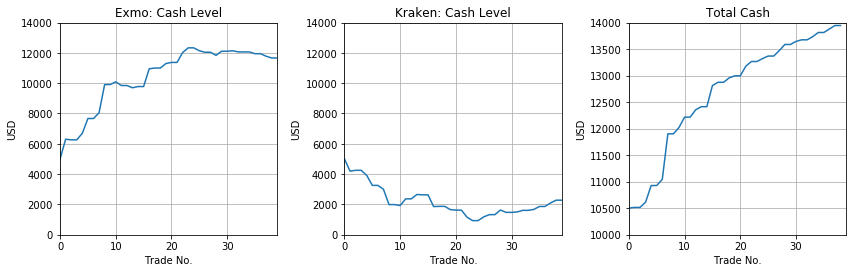

In [12]:
# Plots to display cash levels in each exchange

plt.figure(figsize=(12,7))
 
plt.subplot(2,3,1)
plt.plot(ac1)
plt.title("Exmo: Cash Level")
plt.xlabel("Trade No."); plt.ylabel("USD")
plt.grid()
plt.xlim([0, len(money)])
plt.ylim([0, 14001])
 
plt.subplot(2,3,2)
plt.plot(ac2)
plt.title("Kraken: Cash Level")
plt.xlabel("Trade No."); plt.ylabel("USD")
plt.grid()
plt.xlim([0, len(money)])
plt.ylim([0, 14001])
 
plt.subplot(2,3,3)
plt.plot(np.array(money))
plt.title("Total Cash")
plt.xlabel("Trade No."); plt.ylabel("USD")
plt.grid()
plt.xlim([0, len(money)])
plt.ylim([investment, 14000])
 
plt.tight_layout()
plt.savefig('cashlevels.png', bbox_inches='tight')

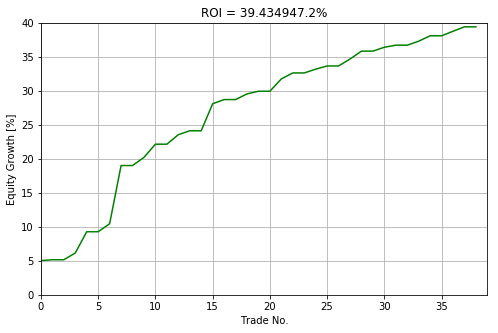

In [13]:
# Plot of ROI of Stat Arb 
plt.figure(figsize=(8,5))
plt.plot(np.array(roi)*100, 'g')
plt.xlabel("Trade No."); 
plt.ylabel("Equity Growth [%]")
plt.title("ROI = %f.2%%" % (100*roi[-1]))
plt.xlim([0, len(money)])
plt.ylim([0, 40])
plt.grid()
plt.savefig('roi.png', bbox_inches='tight')